In [48]:
from finite_difference import central_difference
import gpytorch
from LODEGP.LODEGP import LODEGP, list_standard_models
import matplotlib.pyplot as plt
import numpy as np
import torch



In [49]:
def plot_data(X, Y, return_figure=False, title_add="", fig=None, ax=None, display_figure=True):
    if not (fig and ax):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
    ax.plot(X.numpy(), Y.numpy(), 'k.')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f"Data {title_add}")
    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax




def plot_model(model, likelihood, X, Y, display_figure=True, return_figure=False, figure=None,
               ax=None, loss_val=None, loss_type = None):
    interval_length = torch.max(X) - torch.min(X)
    shift = interval_length * 0.0 
    test_x = torch.linspace(torch.min(
        X) - shift, torch.max(X) + shift, 1000)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))

    with torch.no_grad():
        if not (figure and ax):
            figure, ax = plt.subplots(1, 1, figsize=(8, 6))

        lower, upper = observed_pred.confidence_region()
        ax.plot(X.numpy(), Y.numpy(), 'k.', zorder=2)
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), color="b", zorder=3)
        amount_of_gradient_steps = 30
        alpha_min = 0.05
        alpha_max = 0.8
        alpha = (alpha_max-alpha_min)/amount_of_gradient_steps
        c = ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(
        ), alpha=alpha+alpha_min, zorder=1).get_facecolor()

        for i in range(1, amount_of_gradient_steps):
            ax.fill_between(test_x.numpy(), (lower+(i/amount_of_gradient_steps)*(upper-lower)).numpy(),
                            (upper-(i/amount_of_gradient_steps)*(upper-lower)).numpy(), alpha=alpha, color=c, zorder=1)
        ax.plot([], [], 'k.', label="Data")
        ax.plot([], [], 'b', label="Mean")
        ax.plot([], [], color=c, alpha=1.0, label="Confidence")
        ax.legend(loc="upper left")
        ax.set_xlabel("Normalized Input")
        ax.set_ylabel("Normalized Output")
        ax.set_title(f"{loss_type}: {loss_val:.2f}")
    if not return_figure and display_figure:
        plt.show()
    else:
        return figure, ax

In [ ]:
def plot_gp_predictions(
    X_train, Y_train, 
    X_test, Y_pred_mean, Y_pred_var, 
    n_std=2,
    show=True, 
    return_fig=False,
    fig=None, 
    ax=None,
    colors=None,
    ncols=1,
    figsize=None,
    titles=None,
    xlabel="Input",
    ylabel="Output"
):
    """
    Plot predictions from a single- or multi-output Gaussian Process model.

    Parameters:
    - X_train: (N,) training inputs
    - Y_train: (N,) or (N, D) training outputs
    - X_test: (M,) test inputs
    - Y_pred_mean: (M,) or (M, D) predicted mean at test inputs
    - Y_pred_var: (M,) or (M, D) predicted variance at test inputs
    - n_std: credible interval size (default: 2)
    - show: whether to call plt.show()
    - return_fig: whether to return fig
    - fig, ax: external matplotlib figure/axes
    - colors: optional list of colors for different outputs
    - ncols: number of columns in subplot layout
    - figsize: figure size tuple
    - titles: list of subplot titles or single base title string
    - xlabel: x-axis label (shared or per-plot)
    - ylabel: y-axis label (shared or per-plot)
    
    Returns:
    - fig if return_fig is True
    """

    # Input normalization
    X_train = np.asarray(X_train).squeeze()
    X_test = np.asarray(X_test).squeeze()
    Y_train = np.asarray(Y_train)
    Y_pred_mean = np.asarray(Y_pred_mean)
    Y_pred_var = np.asarray(Y_pred_var)

    if Y_train.ndim == 1:
        Y_train = Y_train[:, np.newaxis]
    if Y_pred_mean.ndim == 1:
        Y_pred_mean = Y_pred_mean[:, np.newaxis]
    if Y_pred_var.ndim == 1:
        Y_pred_var = Y_pred_var[:, np.newaxis]

    num_outputs = Y_train.shape[1]

    # Handle colors
    if colors is None:
        colors = plt.cm.tab10.colors  # default color cycle
    if len(colors) < num_outputs:
        colors = (colors * ((num_outputs // len(colors)) + 1))[:num_outputs]

    # Handle subplot layout
    nrows = int(np.ceil(num_outputs / ncols))
    if ax is None or fig is None:
        fig, ax = plt.subplots(nrows, ncols, figsize=figsize or (5 * ncols, 3 * nrows), squeeze=False)
    ax = ax.flatten()

    # Handle titles
    if isinstance(titles, str):
        titles = [f"{titles} {i}" for i in range(num_outputs)]
    elif titles is None:
        titles = [f"Output Dimension {i}" for i in range(num_outputs)]

    for i in range(num_outputs):
        ax_i = ax[i]

        color = colors[i]

        # Training data
        ax_i.scatter(X_train, Y_train[:, i], color='black', s=20, label='Training Data', zorder=3, marker='x')

        # Posterior mean
        ax_i.plot(X_test, Y_pred_mean[:, i], color=color, label='Posterior Mean')

        # Credible interval
        std_dev = np.sqrt(Y_pred_var[:, i])
        lower = Y_pred_mean[:, i] - n_std * std_dev
        upper = Y_pred_mean[:, i] + n_std * std_dev
        ax_i.fill_between(X_test, lower, upper, color=color, alpha=0.3, label=f'{n_std}$\sigma$ Interval')

        # Titles and labels
        ax_i.set_title(titles[i])
        ax_i.set_xlabel(xlabel)
        ax_i.set_ylabel(ylabel)
        ax_i.legend()
        ax_i.grid(True)

    # Hide unused subplots if any
    for j in range(num_outputs, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()

    if show:
        plt.show()

    if return_fig:
        return fig

<>:92: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1291409/3788122157.py:92: SyntaxWarning: invalid escape sequence '\s'
  ax_i.fill_between(X_test, lower, upper, color=color, alpha=0.3, label=f'{n_std}$\sigma$ Interval')


In [51]:
START = 2
END = 12
COUNT = 100
train_x = torch.linspace(START, END, COUNT)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)

y0_func = lambda x: float(781/8000)*torch.sin(x)/x - float(1/20)*torch.cos(x)/x**2 + float(1/20)*torch.sin(x)/x**3
y1_func = lambda x: float(881/8000)*torch.sin(x)/x - float(1/40)*torch.cos(x)/x**2 + float(1/40)*torch.sin(x)/x**3
y2_func = lambda x: float(688061/800000)*torch.sin(x)/x - float(2543/4000)*torch.cos(x)/x**2 + float(1743/4000)*torch.sin(x)/x**3 - float(3/5)*torch.cos(x)/x**4 + float(3/5)*torch.sin(x)/x**5 
y0 = y0_func(train_x)
y1 = y1_func(train_x)
y2 = y2_func(train_x)
train_y = torch.stack([y0, y1, y2], dim=1)

model = LODEGP(train_x, train_y, likelihood, 3, ODE_name="Bipendulum", verbose=True, system_parameters={"l1": 1.0, "l2": 2.0})

D:[1 0 0]
[0 1 0]
V:[                                0                          -400/981                     x^2 + 981/200]
[                                0                          -200/981                 1/2*x^2 + 981/200]
[                               -1                  -400/981*x^2 - 4 x^4 + 2943/200*x^2 + 962361/20000]
[[0, -400/981, x^2 + 981/200], [0, -200/981, 1/2*x^2 + 981/200], [-1, -400/981*x^2 - 4, x^4 + 2943/200*x^2 + 962361/20000]]
ParameterDict(
    (signal_variance_2): Parameter containing: [torch.FloatTensor of size ]
    (lengthscale_2): Parameter containing: [torch.FloatTensor of size ]
)


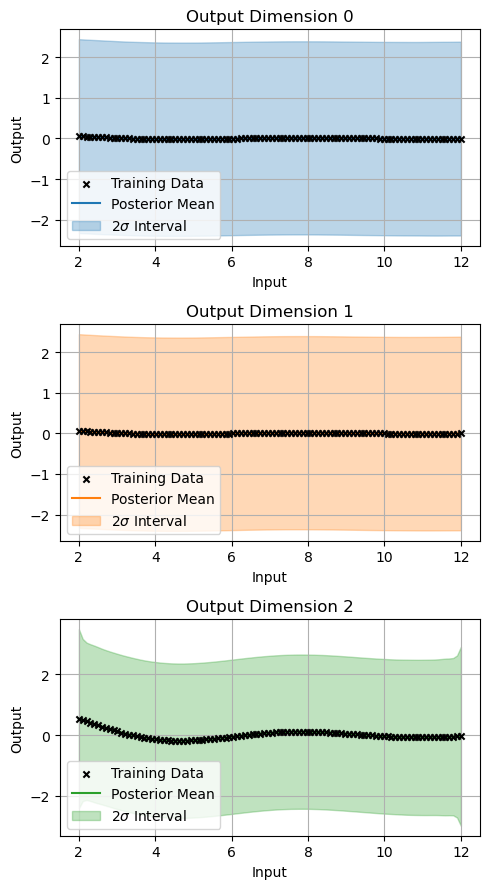

In [56]:
# Plot the posterior GP and the data
model.eval()
model.likelihood.eval()
with torch.no_grad():
    test_x = torch.linspace(2, 12, 100)
    observed_pred = model.likelihood(model(test_x))
    observed_pred_mean = observed_pred.mean
    observed_pred_var = observed_pred.covariance_matrix.diag().reshape(-1, 3)
    plot_gp_predictions(train_x, train_y, test_x, observed_pred_mean, observed_pred_var)